In this notebook we will be attempting to reshape the problem a bit. Instead of applying RNNs directly to the time series, we'll instead recast the problem as a classification with traditional machine learning models. This method may be preferable if speed is an important factor and the metrics are still satisfactory.

In [201]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
class Modeller:
    def __init__(self, raw_df):
        self.raw_df = raw_df
        
    def preprocess(self, avg=None, shift=None, n_lags=None, n_obs=None,
                   classification=False, threshold=30, test_size=None):
        df = self.raw_df.copy()
        
        df['weekday'] = (df.index.dayofweek < 5).astype(int)
        df['work_hour'] = ((df.index.hour >= 5) & (df.index.hour <=15)).astype(int)
        df.drop(columns = ['AWD_cos', 'AWD_sin'], inplace=True)
        
        if avg:
            df = df.resample(avg).mean()
            
        if shift:
            df = df_shift(df, n_lags, n_obs)
            
        if classification:
            df['harmful (t)'] = (df['Sample Value (t)'] > threshold).astype(int)
            df.drop('Sample Value (t)', axis=1, inplace=True)
            
        if test_size:
            cat_names = ['weekday', 'work_hour']
            cat_cols = []
            for name in cat_names:
                for col in shifted_aqi_df.columns:
                    if name in col:
                        cat_cols.append(col)
            
            X = df[df.columns[:-1]]
            y = df[df.columns[-1]]
            
            self.feat_labels = X.columns
                        
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
            X_train_num = X_train.drop(cat_cols, axis=1)
            X_train_cat = X_train[cat_cols]
            X_test_num = X_test.drop(cat_cols, axis=1)
            X_test_cat = X_test[cat_cols]

            X_scaler = StandardScaler()
            X_train_num_scaled = X_scaler.fit_transform(X_train_num)
            X_test_num_scaled = X_scaler.transform(X_test_num)

            X_train_scaled = np.concatenate((X_train_num_scaled, X_train_cat.values), axis=1)
            X_test_scaled = np.concatenate((X_test_num_scaled, X_test_cat.values), axis=1)
            
        
                        
            
            
        

In [202]:
aqi_df = pd.read_csv("../data/sh_bell/combined_meteor_and_sample.csv", index_col='Unnamed: 0', parse_dates=True)

In [203]:
aqi_df.drop(columns = ['AWD_cos', 'AWD_sin'], inplace=True)

In [204]:
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,Sample Value
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,4.0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,6.0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,7.0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,6.0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,8.0


In [205]:
aqi_df['weekday'] = (aqi_df.index.dayofweek < 5).astype(int)
aqi_df['work_hour'] = ((aqi_df.index.hour >= 5) & (aqi_df.index.hour <=15)).astype(int)
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,Sample Value,weekday,work_hour
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,4.0,0,0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,6.0,0,0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,7.0,0,0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,6.0,0,0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,8.0,0,0


With this function, we can generate dataframes that have features from t - n_lags to t - 1, and observations from t to t + n_obs.

In [207]:
shifted_aqi_df = df_shift(aqi_df.copy(), 24, 1)
# shifted_aqi_df_8h_mean = df_shift(aqi_df.copy().resample('8h').mean(), 6, 1)
# shifted_aqi_df_8h_mean.head()

Now, we'll bin the sample values at times t based on their concentrations. There are no defined standards for 1 hour levels that I could find. And as discussed in the readme, the EPA is already rather conservative with the 24 hour levels that they have defined. Here, I'll be rather conservative and say that anything over 50 $\mu g / m^{3}$ should be considered harmful.

In [208]:
shifted_aqi_df['harmful'] = (shifted_aqi_df['Sample Value (t)'] > 30).astype(int)
shifted_aqi_df.drop('Sample Value (t)', axis=1, inplace=True)

In [209]:
shifted_aqi_df.reset_index(inplace=True)
shifted_aqi_df.drop('index', axis=1, inplace=True)

In [210]:
shifted_aqi_df['harmful'].value_counts()

0    16802
1     6550
Name: harmful, dtype: int64

We can see here that there's a little bit of a class imbalance. This will maybe be addressed with random undersampling.

In [211]:
cat_names = ['weekday', 'work_hour']
cat_cols = []
for name in cat_names:
    for col in shifted_aqi_df.columns:
        if name in col:
            cat_cols.append(col)

In [212]:
X = shifted_aqi_df[shifted_aqi_df.columns[:-1]]
y = shifted_aqi_df[shifted_aqi_df.columns[-1]]

In [213]:
feat_labels = X.columns

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
X_train_num = X_train.drop(cat_cols, axis=1)
X_train_cat = X_train[cat_cols]
X_test_num = X_test.drop(cat_cols, axis=1)
X_test_cat = X_test[cat_cols]

X_scaler = StandardScaler()
X_train_num_scaled = X_scaler.fit_transform(X_train_num)
X_test_num_scaled = X_scaler.transform(X_test_num)

X_train_scaled = np.concatenate((X_train_num_scaled, X_train_cat.values), axis=1)
X_test_scaled = np.concatenate((X_test_num_scaled, X_test_cat.values), axis=1)
# rus = RandomUnderSampler()
# X_rus, y_rus = rus.fit_sample(X_train, y_train)

In [215]:
model = RandomForestClassifier(n_estimators=100, bootstrap=True)
# model = XGBClassifier(max_depth=4, learning_rate=0.05, n_jobs=2)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [216]:
sfm = SelectFromModel(model, threshold=0.05)
sfm.fit(X_train_scaled, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [217]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Sample Value (t-9)
AvgT Deg_F Avg (t-8)
AWS Mph WVc (t-7)


In [218]:
X_important_train = sfm.transform(X_train_scaled)
X_important_test = sfm.transform(X_test_scaled)

In [219]:
model_important = RandomForestClassifier(n_estimators=100, bootstrap=True)
model_important.fit(X_important_train, y_train)
y_important_pred = model_important.predict(X_important_test)

In [220]:
recall_score(y_test, y_important_pred)

0.6954887218045113

In [221]:
y_pred = model.predict(X_test_scaled)

In [225]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

roc_value = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [226]:
fpr, tpr, thresh = roc_curve(y_test, y_pred)

In [227]:
cm

array([[5166,  413],
       [ 671, 1457]], dtype=int64)

In [228]:
accuracy_score(y_test, y_important_pred)

0.8352147398468924

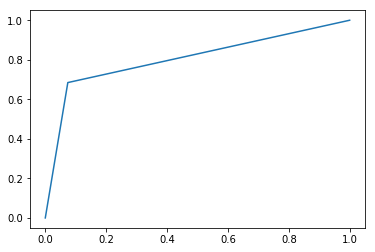

In [229]:
plt.plot(fpr, tpr)

In [ ]:
class Modeller:
    def __init__(self, raw_df):
        self.raw_df = raw_df
        
    def 
    